15:08:35 - cmdstanpy - INFO - Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] done processing


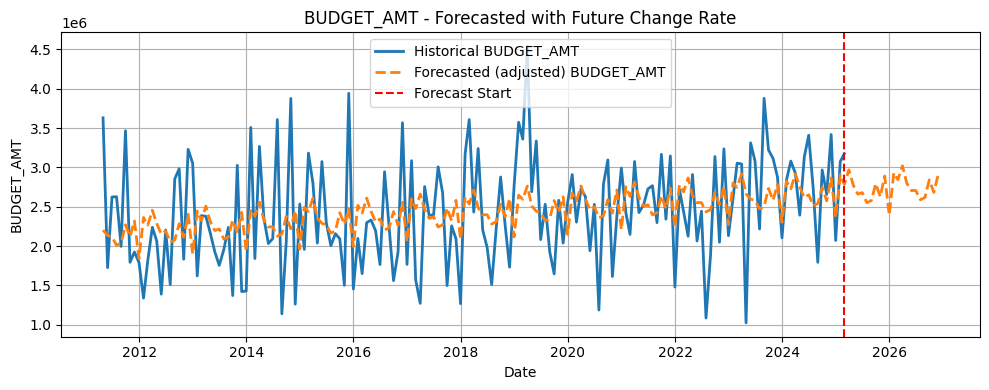

15:08:35 - cmdstanpy - INFO - Chain [1] start processing
15:08:35 - cmdstanpy - INFO - Chain [1] done processing


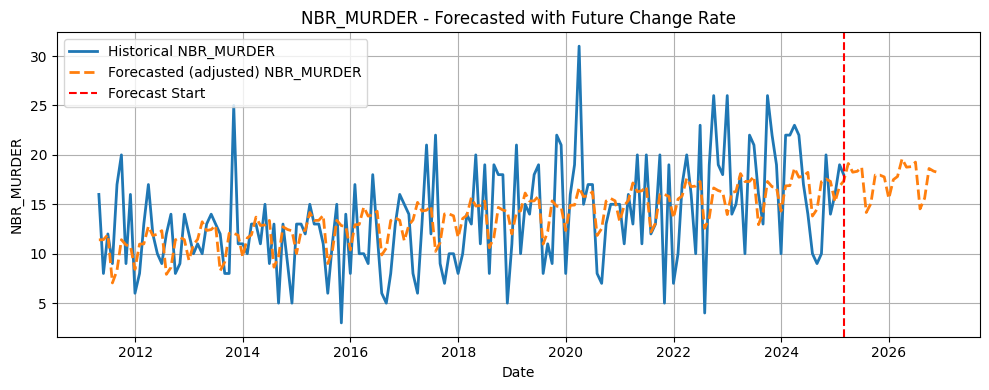

15:08:36 - cmdstanpy - INFO - Chain [1] start processing
15:08:36 - cmdstanpy - INFO - Chain [1] done processing


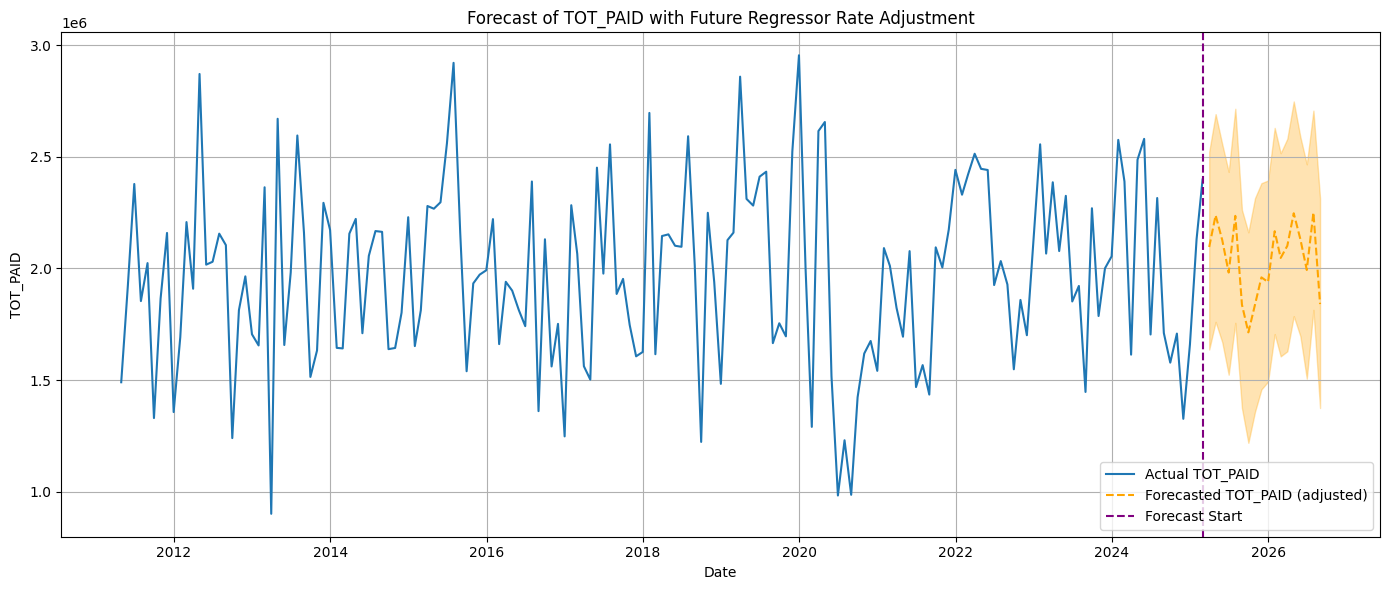


📁 Regressor forecasts saved to 'regressor_forecasts.csv'

🔮 Forecasted TOT_PAID from 2025-03-31:
           ds          yhat    yhat_lower    yhat_upper
0  2025-03-31  2.096276e+06  1.636550e+06  2.523192e+06
1  2025-04-30  2.238561e+06  1.760697e+06  2.692066e+06
2  2025-05-31  2.127128e+06  1.669316e+06  2.557018e+06
3  2025-06-30  1.981839e+06  1.523745e+06  2.433059e+06
4  2025-07-31  2.235879e+06  1.756361e+06  2.716186e+06
5  2025-08-31  1.837607e+06  1.373691e+06  2.262635e+06
6  2025-09-30  1.713506e+06  1.218360e+06  2.162015e+06
7  2025-10-31  1.837874e+06  1.357667e+06  2.315307e+06
8  2025-11-30  1.960126e+06  1.457904e+06  2.382296e+06
9  2025-12-31  1.939300e+06  1.492751e+06  2.394461e+06
10 2026-01-31  2.167236e+06  1.705921e+06  2.630295e+06
11 2026-02-28  2.047271e+06  1.605955e+06  2.516641e+06
12 2026-03-31  2.101621e+06  1.628645e+06  2.581544e+06
13 2026-04-30  2.247586e+06  1.786279e+06  2.748782e+06
14 2026-05-31  2.131469e+06  1.696687e+06  2.589780e+06
15 202

In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18


# === Step 3: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # === Plot regressor trend ===
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted (adjusted) {reg}', linewidth=2)
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted with Future Change Rate")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 4: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 5: Prepare future forecast dataframe ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='ME')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 6: Train Prophet on full historical data ===
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 7: Forecast TOT_PAID using adjusted regressors ===
forecast = model.predict(future_df)

# === Step 8: Plot final TOT_PAID forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['TOT_PAID'], label='Actual TOT_PAID')
plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecasted TOT_PAID (adjusted)', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.axvline(x=last_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("Forecast of TOT_PAID with Future Regressor Rate Adjustment")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 3.6: Save regressor forecasts to CSV ===
# Merge forecasted future values for each regressor
merged_regressor_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    reg_future_forecast = regressor_forecasts[reg][regressor_forecasts[reg]['ds'] >= forecast_start][['ds', reg]]
    merged_regressor_df = merged_regressor_df.merge(reg_future_forecast, on='ds', how='left')

# Save to CSV
merged_regressor_df.to_csv("C:/GitHub\Machine-Learning/data/regressor_forecasts.csv", index=False)
print("\n📁 Regressor forecasts saved to 'regressor_forecasts.csv'")

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("C:/GitHub\Machine-Learning/data/TOT_Paidforecasts.csv", index=False)

# === Step 9: Display forecast ===
print(f"\n🔮 Forecasted TOT_PAID from {forecast_start.date()}:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])




15:27:58 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing



📊 Measuring sensitivity to: BUDGET_AMT
🔹 Average sensitivity of TOT_PAID to BUDGET_AMT: 0.08


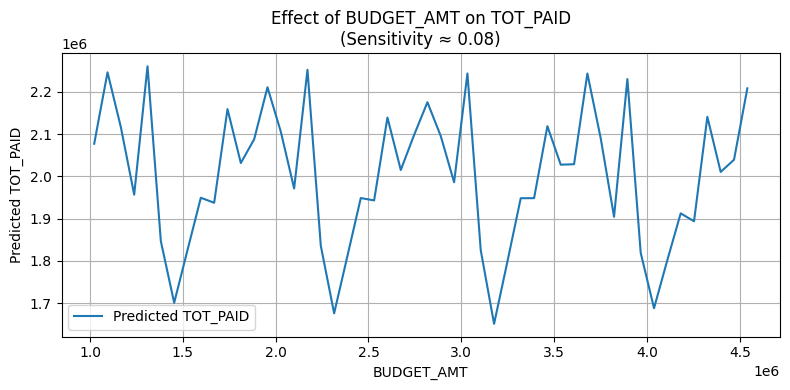


📊 Measuring sensitivity to: NBR_MURDER
🔹 Average sensitivity of TOT_PAID to NBR_MURDER: 20471.08


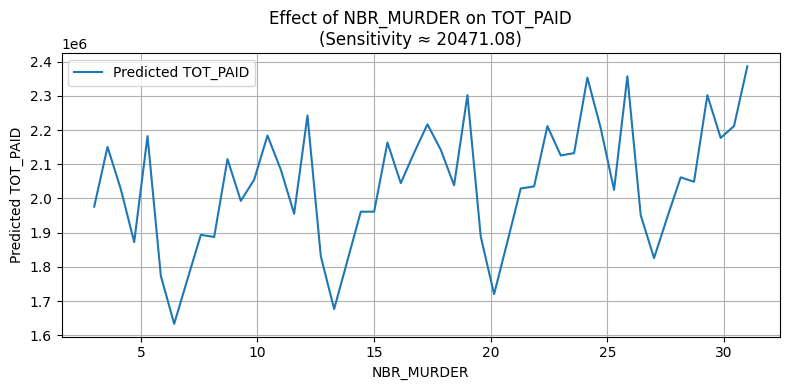


📈 Sensitivity Summary:
→ BUDGET_AMT: 0.08 units change in TOT_PAID per 1 unit change in BUDGET_AMT
→ NBR_MURDER: 20471.08 units change in TOT_PAID per 1 unit change in NBR_MURDER


In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data and train full model ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']

model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)

df_model = df[['ds', 'y'] + regressors].dropna()
model.fit(df_model)

# === Step 2: Sensitivity function ===
def measure_regressor_sensitivity(model, df, regressor, steps=50):
    print(f"\n📊 Measuring sensitivity to: {regressor}")

    reg_range = np.linspace(df[regressor].min(), df[regressor].max(), steps)
    other_regressors = {r: df[r].median() for r in regressors if r != regressor}

    future_dates = pd.date_range(start=df['ds'].max() + pd.offsets.MonthEnd(1), periods=steps, freq='ME')
    sens_df = pd.DataFrame({'ds': future_dates})
    sens_df[regressor] = reg_range
    for r, val in other_regressors.items():
        sens_df[r] = val

    forecast = model.predict(sens_df)
    yhat = forecast['yhat'].values

    # Calculate sensitivity (approx. derivative)
    dy = np.gradient(yhat)
    dx = np.gradient(reg_range)
    sensitivity = dy / dx

    avg_sensitivity = np.mean(sensitivity)
    print(f"🔹 Average sensitivity of TOT_PAID to {regressor}: {avg_sensitivity:.2f}")

    # Optional: plot
    plt.figure(figsize=(8, 4))
    plt.plot(reg_range, yhat, label='Predicted TOT_PAID')
    plt.title(f"Effect of {regressor} on TOT_PAID\n(Sensitivity ≈ {avg_sensitivity:.2f})")
    plt.xlabel(regressor)
    plt.ylabel("Predicted TOT_PAID")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_sensitivity

# === Step 3: Run for all regressors ===
sensitivity_results = {}
for reg in regressors:
    sensitivity_results[reg] = measure_regressor_sensitivity(model, df_model, reg)

# === Optional: print summary ===
print("\n📈 Sensitivity Summary:")
for reg, val in sensitivity_results.items():
    print(f"→ {reg}: {val:.2f} units change in TOT_PAID per 1 unit change in {reg}")


15:33:43 - cmdstanpy - INFO - Chain [1] start processing
15:33:43 - cmdstanpy - INFO - Chain [1] done processing
c:\GitHub\Machine-Learning\.venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



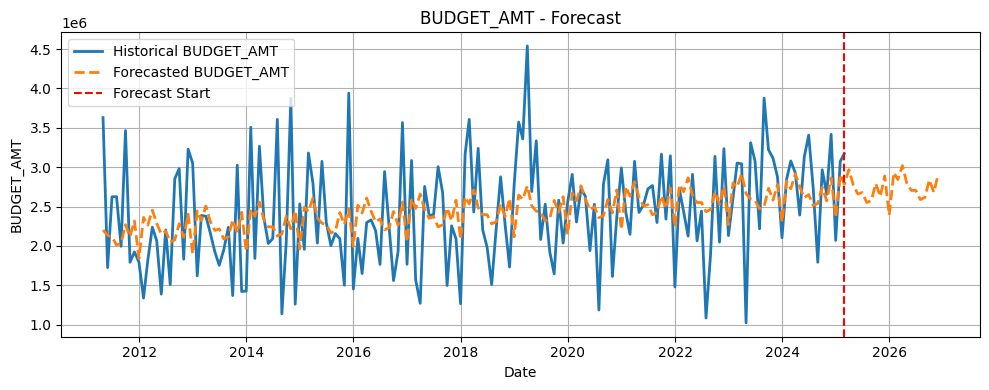

C:\Users\Admin\AppData\Local\Temp\ipykernel_20644\1814291120.py:57: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

15:33:43 - cmdstanpy - INFO - Chain [1] start processing
15:33:43 - cmdstanpy - INFO - Chain [1] done processing


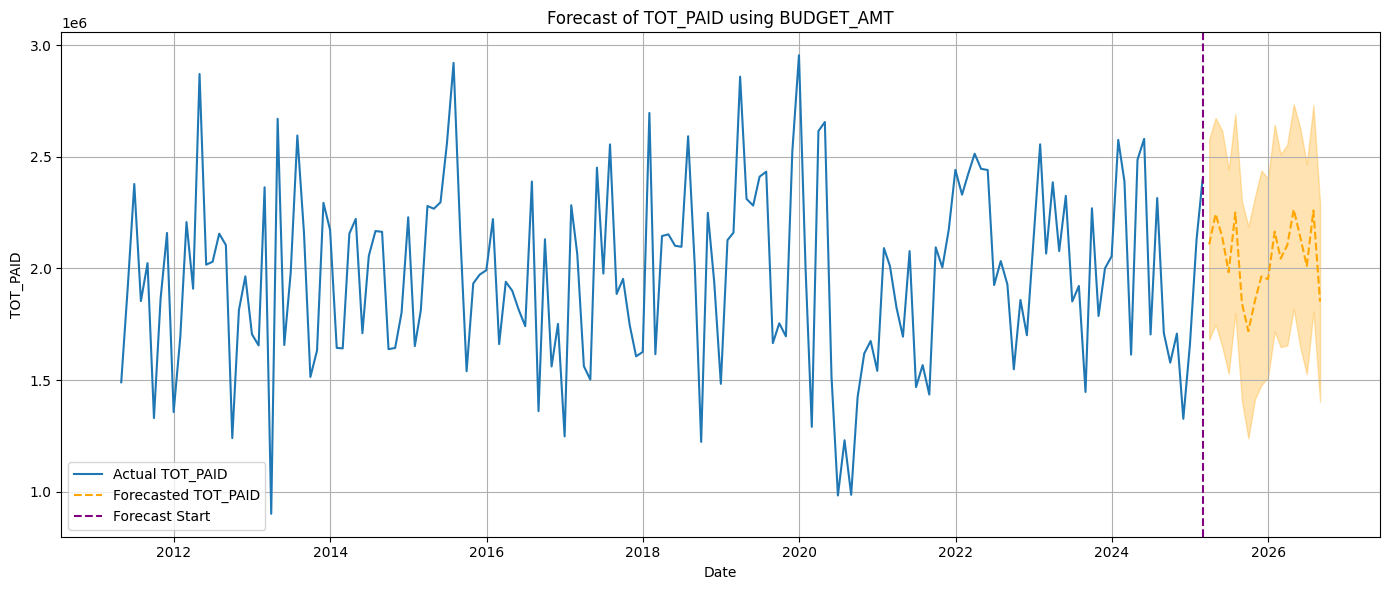


📁 Forecasts saved to CSV files.

🔮 Forecasted TOT_PAID from 2025-03-31:
           ds          yhat    yhat_lower    yhat_upper
0  2025-03-31  2.108113e+06  1.679461e+06  2.579412e+06
1  2025-04-30  2.244558e+06  1.750094e+06  2.674723e+06
2  2025-05-31  2.140750e+06  1.649277e+06  2.617339e+06
3  2025-06-30  1.983255e+06  1.528242e+06  2.443302e+06
4  2025-07-31  2.250921e+06  1.799430e+06  2.692602e+06
5  2025-08-31  1.844143e+06  1.404718e+06  2.301635e+06
6  2025-09-30  1.718908e+06  1.238346e+06  2.188182e+06
7  2025-10-31  1.856574e+06  1.414963e+06  2.320855e+06
8  2025-11-30  1.964422e+06  1.477187e+06  2.439245e+06
9  2025-12-31  1.952182e+06  1.512298e+06  2.403146e+06
10 2026-01-31  2.165450e+06  1.717812e+06  2.644732e+06
11 2026-02-28  2.044404e+06  1.647438e+06  2.511221e+06
12 2026-03-31  2.104741e+06  1.655641e+06  2.556588e+06
13 2026-04-30  2.264275e+06  1.818452e+06  2.736341e+06
14 2026-05-31  2.139120e+06  1.644221e+06  2.627246e+06
15 2026-06-30  2.010716e+06  1.

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT']
forecast_horizon = 18

# === Step 2: Forecast BUDGET_AMT ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='M')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)

    regressor_forecasts[reg] = reg_forecast

    # === Plot regressor trend ===
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted {reg}', linewidth=2)
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecast")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 3: Merge forecast with full data ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 4: Prepare future forecast input ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='M')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 5: Train Prophet model using BUDGET_AMT only ===
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
model.add_regressor('BUDGET_AMT')
model.fit(train_df)

# === Step 6: Forecast TOT_PAID ===
forecast = model.predict(future_df)

# === Step 7: Plot final TOT_PAID forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['TOT_PAID'], label='Actual TOT_PAID')
plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecasted TOT_PAID', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.axvline(x=last_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("Forecast of TOT_PAID using BUDGET_AMT")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 8: Save to CSV ===
merged_regressor_df = regressor_forecasts['BUDGET_AMT'][regressor_forecasts['BUDGET_AMT']['ds'] >= forecast_start]
merged_regressor_df.to_csv("C:/GitHub/Machine-Learning/data/regressor_forecasts.csv", index=False)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("C:/GitHub/Machine-Learning/data/TOT_Paidforecasts.csv", index=False)

print("\n📁 Forecasts saved to CSV files.")
print(f"\n🔮 Forecasted TOT_PAID from {forecast_start.date()}:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


In [16]:
df.head()

,ACC_MONTH,FISCAL_YEAR,ACCOUNTING_PERIOD,TOT_PAID,BUDGET_AMT,NBR_CASE,NBR_MURDER,NBR_OTHER,ds,y
0,2011-04-30,2011,1,1489878.86,3629805.06,62,16,46,2011-04-30,1489878.86
1,2011-05-31,2011,2,1922713.79,1724956.61,41,8,33,2011-05-31,1922713.79
2,2011-06-30,2011,3,2378873.09,2623665.50,38,12,26,2011-06-30,2378873.09
3,2011-07-31,2011,4,1853901.62,2626410.66,49,9,40,2011-07-31,1853901.62
4,2011-08-31,2011,5,2024100.54,1995629.23,33,17,16,2011-08-31,2024100.54


In [17]:
df[['TOT_PAID', 'BUDGET_AMT', 'NBR_CASE','NBR_MURDER','NBR_OTHER']].corr()

,TOT_PAID,BUDGET_AMT,NBR_CASE,NBR_MURDER,NBR_OTHER
TOT_PAID,1.000000,0.040651,0.137807,0.093982,0.121304
BUDGET_AMT,0.040651,1.000000,0.665593,0.424706,0.600371
NBR_CASE,0.137807,0.665593,1.000000,0.604419,0.918700
NBR_MURDER,0.093982,0.424706,0.604419,1.000000,0.240632
NBR_OTHER,0.121304,0.600371,0.918700,0.240632,1.000000


In [30]:
import pandas as pd

# === Step 1: Load the uploaded file ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# === Step 2: Create lagged columns ===
df['BUDGET_AMT_lag2'] = df['BUDGET_AMT'].shift(2)
df['BUDGET_AMT_lag8'] = df['BUDGET_AMT'].shift(8)
df['BUDGET_AMT_lag12'] = df['BUDGET_AMT'].shift(12)
df['NBR_MURDER_lag1'] = df['NBR_MURDER'].shift(1)
df['NBR_MURDER_lag2'] = df['NBR_MURDER'].shift(2)
df['NBR_MURDER_lag20'] = df['NBR_MURDER'].shift(20)
df['NBR_CASES_lag2'] = df['NBR_CASE'].shift(2)
df['NBR_CASES_lag11'] = df['NBR_CASE'].shift(11)



# === Step 3: Drop rows with missing lagged values ===
df_lagged = df.dropna(subset=['BUDGET_AMT_lag12', 'NBR_MURDER_lag20']).copy()

df_2 = df_lagged[['ACC_MONTH','TOT_PAID','BUDGET_AMT','BUDGET_AMT_lag2','BUDGET_AMT_lag8','BUDGET_AMT_lag12','NBR_MURDER','NBR_MURDER_lag1','NBR_MURDER_lag2','NBR_MURDER_lag20','NBR_CASE','NBR_CASES_lag2','NBR_CASES_lag11']]

In [26]:
df_2.corr()

,TOT_PAID,BUDGET_AMT,BUDGET_AMT_lag2,BUDGET_AMT_lag8,BUDGET_AMT_lag12,NBR_MURDER,NBR_MURDER_lag1,NBR_MURDER_lag2,NBR_MURDER_lag20,NBR_CASE,NBR_CASES_lag2,NBR_CASES_lag11
TOT_PAID,1.000000,0.081377,0.240853,0.148969,0.126892,0.087812,0.200458,0.169343,0.169446,0.163978,0.157703,0.153367
BUDGET_AMT,0.081377,1.000000,0.060687,0.075422,0.069196,0.413265,0.006985,0.113728,0.196365,0.665402,0.056349,0.080090
BUDGET_AMT_lag2,0.240853,0.060687,1.000000,0.040783,-0.078252,0.069696,0.044040,0.408212,0.050057,0.073978,0.670047,0.192424
BUDGET_AMT_lag8,0.148969,0.075422,0.040783,1.000000,-0.086161,0.194521,0.061015,0.123443,0.203165,0.071495,-0.040001,0.174154
BUDGET_AMT_lag12,0.126892,0.069196,-0.078252,-0.086161,1.000000,0.144993,0.164701,0.013143,0.081437,0.094801,-0.064510,0.079280
NBR_MURDER,0.087812,0.413265,0.069696,0.194521,0.144993,1.000000,0.144427,0.157143,0.191985,0.618649,0.031812,0.210551
NBR_MURDER_lag1,0.200458,0.006985,0.044040,0.061015,0.164701,0.144427,1.000000,0.139561,0.051345,0.064338,0.020947,0.092941
NBR_MURDER_lag2,0.169343,0.113728,0.408212,0.123443,0.013143,0.157143,0.139561,1.000000,0.178191,0.148361,0.617060,0.063252
NBR_MURDER_lag20,0.169446,0.196365,0.050057,0.203165,0.081437,0.191985,0.051345,0.178191,1.000000,0.178028,-0.005420,0.213198
NBR_CASE,0.163978,0.665402,0.073978,0.071495,0.094801,0.618649,0.064338,0.148361,0.178028,1.000000,0.187935,0.198682


15:55:22 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing


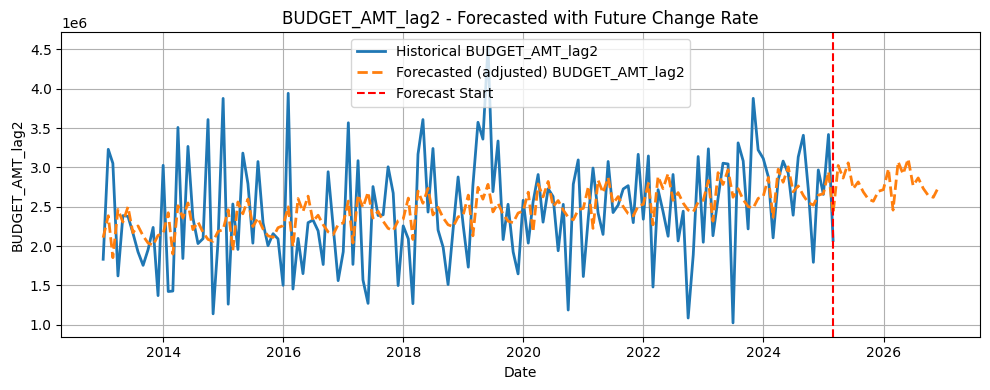

15:55:22 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing


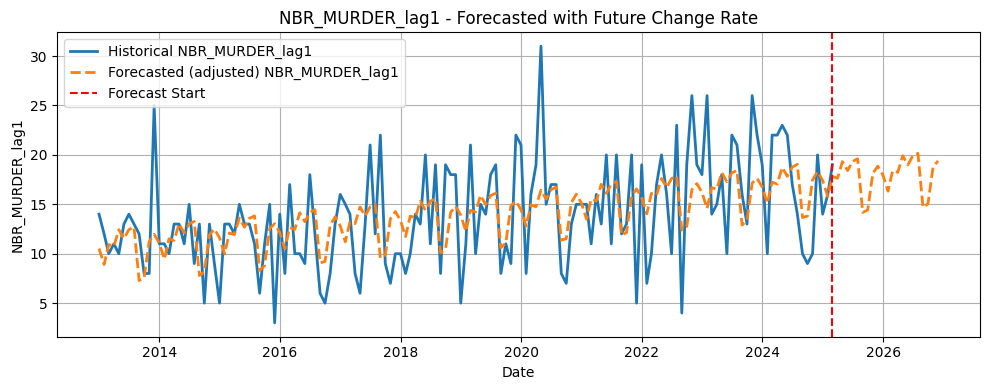

15:55:23 - cmdstanpy - INFO - Chain [1] start processing
15:55:23 - cmdstanpy - INFO - Chain [1] done processing


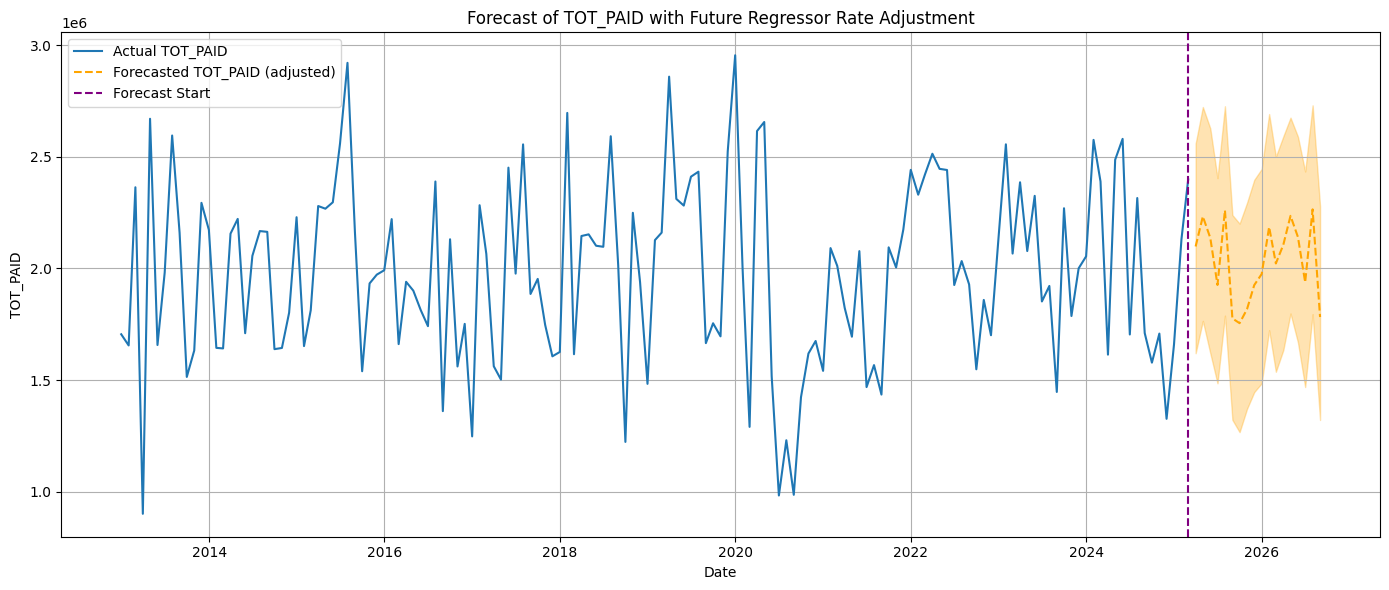


📁 Regressor forecasts saved to 'regressor_forecasts.csv'

🔮 Forecasted TOT_PAID from 2025-03-31:
           ds          yhat    yhat_lower    yhat_upper
0  2025-03-31  2.098729e+06  1.620049e+06  2.560243e+06
1  2025-04-30  2.233372e+06  1.765014e+06  2.723938e+06
2  2025-05-31  2.137116e+06  1.620211e+06  2.628109e+06
3  2025-06-30  1.926116e+06  1.485200e+06  2.405053e+06
4  2025-07-31  2.261132e+06  1.788601e+06  2.727444e+06
5  2025-08-31  1.776201e+06  1.321449e+06  2.239679e+06
6  2025-09-30  1.754784e+06  1.266401e+06  2.201064e+06
7  2025-10-31  1.817909e+06  1.370937e+06  2.294616e+06
8  2025-11-30  1.925589e+06  1.445907e+06  2.397416e+06
9  2025-12-31  1.975137e+06  1.485444e+06  2.446325e+06
10 2026-01-31  2.186223e+06  1.723382e+06  2.692327e+06
11 2026-02-28  2.022517e+06  1.536895e+06  2.501160e+06
12 2026-03-31  2.106062e+06  1.634137e+06  2.591943e+06
13 2026-04-30  2.235935e+06  1.798273e+06  2.676156e+06
14 2026-05-31  2.140691e+06  1.668196e+06  2.590539e+06
15 202

In [31]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
#df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df_2
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT_lag2', 'NBR_MURDER_lag1']
forecast_horizon = 18


# === Step 3: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # === Plot regressor trend ===
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted (adjusted) {reg}', linewidth=2)
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted with Future Change Rate")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 4: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 5: Prepare future forecast dataframe ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='ME')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 6: Train Prophet on full historical data ===
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 7: Forecast TOT_PAID using adjusted regressors ===
forecast = model.predict(future_df)

# === Step 8: Plot final TOT_PAID forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['TOT_PAID'], label='Actual TOT_PAID')
plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecasted TOT_PAID (adjusted)', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.axvline(x=last_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("Forecast of TOT_PAID with Future Regressor Rate Adjustment")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 3.6: Save regressor forecasts to CSV ===
# Merge forecasted future values for each regressor
merged_regressor_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    reg_future_forecast = regressor_forecasts[reg][regressor_forecasts[reg]['ds'] >= forecast_start][['ds', reg]]
    merged_regressor_df = merged_regressor_df.merge(reg_future_forecast, on='ds', how='left')

# Save to CSV
merged_regressor_df.to_csv("C:/GitHub\Machine-Learning/data/regressor_forecasts.csv", index=False)
print("\n📁 Regressor forecasts saved to 'regressor_forecasts.csv'")

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("C:/GitHub\Machine-Learning/data/TOT_Paidforecasts.csv", index=False)

# === Step 9: Display forecast ===
print(f"\n🔮 Forecasted TOT_PAID from {forecast_start.date()}:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])




In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === Step 7.5: Evaluate model accuracy using the last 20% of actuals ===
split_index = int(len(train_df) * 0.8)
train_actuals = train_df.iloc[:split_index]
test_actuals = train_df.iloc[split_index:]

# Predict on historical test data
test_forecast = model.predict(test_actuals[['ds'] + regressors])

# Extract actuals and predictions
y_true = test_actuals['y'].values
y_pred = test_forecast['yhat'].values

# === Accuracy Metrics ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Print Accuracy Results ===
print("\n📊 Forecast Accuracy on Holdout Test Set:")
print(f"🔹 RMSE : {rmse:,.2f}")
print(f"🔹 MAE  : {mae:,.2f}")
print(f"🔹 MAPE : {mape:.2f}%")


📊 Forecast Accuracy on Holdout Test Set:
🔹 RMSE : 282,972.38
🔹 MAE  : 234,940.83
🔹 MAPE : 12.10%


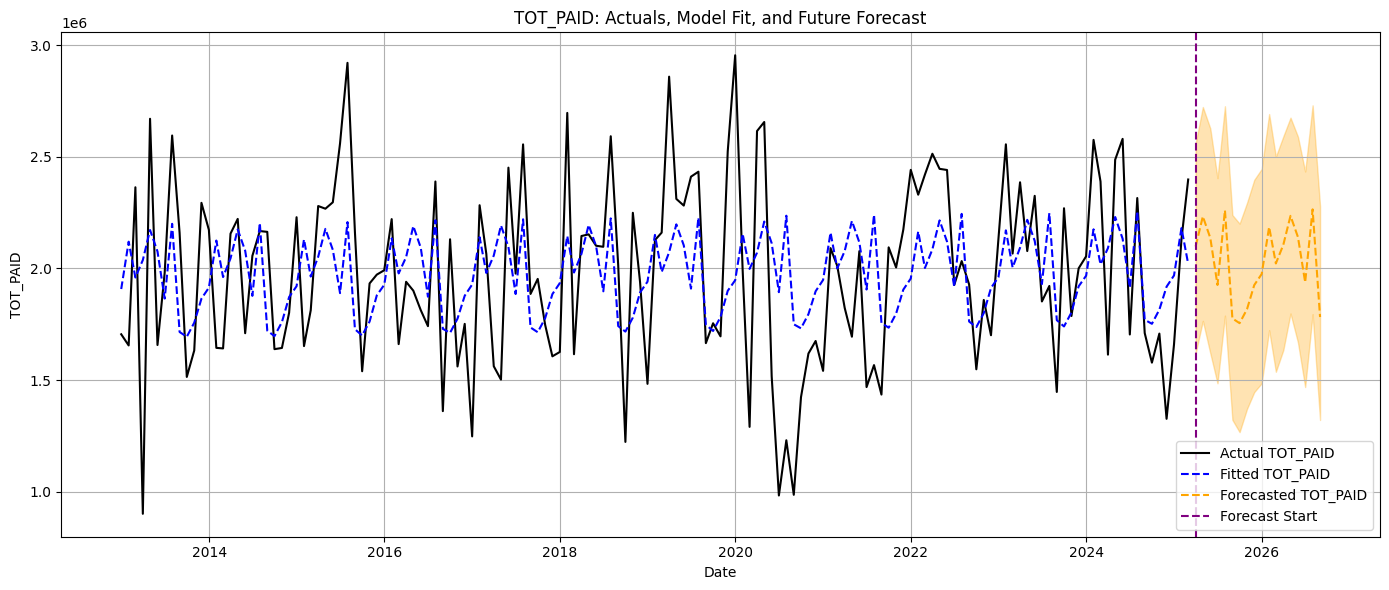

In [33]:
# === Step 8: Full Forecast Plot (Actuals + Predictions + Future Forecast) ===
# Merge predictions with actual data for full timeline visualization
full_timeline = pd.concat([
    train_df[['ds', 'y']].copy().assign(type='Actual'),
    model.predict(train_df[['ds'] + regressors])[['ds', 'yhat']].rename(columns={'yhat': 'y'}).assign(type='Predicted'),
    forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'}).assign(type='Forecast')
], ignore_index=True)

plt.figure(figsize=(14, 6))

# Plot Actuals
actuals = full_timeline[full_timeline['type'] == 'Actual']
plt.plot(actuals['ds'], actuals['y'], label='Actual TOT_PAID', color='black')

# Plot Model Fit
predicted = full_timeline[full_timeline['type'] == 'Predicted']
plt.plot(predicted['ds'], predicted['y'], label='Fitted TOT_PAID', color='blue', linestyle='--')

# Plot Forecast
forecasted = full_timeline[full_timeline['type'] == 'Forecast']
plt.plot(forecasted['ds'], forecasted['y'], label='Forecasted TOT_PAID', color='orange', linestyle='--')

# Add forecast confidence interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)

# Mark forecast start
plt.axvline(x=forecast_start, color='purple', linestyle='--', label='Forecast Start')

plt.title("TOT_PAID: Actuals, Model Fit, and Future Forecast")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()